In [1]:
import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass

from process_gen_utils import *
from process_gens import *


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


In [2]:
# import pandas as pd
# from helm.benchmark.runner import InstanceGenerations,GenerationSummary
# from typing import Any, List
# import json
# from helm.common.request import (GeneratedOutput, Token)

# import PostMetric
# import pandas as pd

# from helm.benchmark.metrics.statistic import Stat
# from typing import Dict, Optional

# from helm.benchmark.augmentations.perturbation_description import (
#     PerturbationDescription)
# from dataclasses import dataclass
# import os

# def assert_dir_exists(dir_name):
#     dirs=dir_name.split("/")
#     for i in range(len(dirs)):
#         prev_dir="/".join(dirs[:i])
#         cur_dir="/".join(dirs[:i+1])
#         if not os.path.isdir(cur_dir):
#             error_str="\n------------------------------------------\n"
#             error_str+="Error:\n"
#             error_str+=f"dir_name does not exist: {dir_name}\n\n"
#             error_str+=f"Directory exists: {prev_dir}\n\n"
#             error_str+=f"Extension does not exist: {dir_name[len(prev_dir)+1:]}\n"
#             error_str+=f"\n\nTo check:\n"
#             error_str+=f"ls {prev_dir}"
#             raise Exception(error_str)
        


# def get_process_gen_params(test_name):

#     def get_metrics(mode):
#         if(mode=="wmt"):
#             task_names=["wmt_14_language_pair_de_en_"]
#             custom_metrics=[ PostMetric.BLEU1_METRIC(),PostMetric.BLEU4_METRIC()]
#             instance_metrics=["comet"]
#         if(mode=="instruct"):
#             print("\n\n----------------\n NOTE: ONLY PRINTING 4 tasks ----------------\n")
#             # task_names=["open_assistant:language=en,num_respondents=1,","self_instruct:num_respondents=1,"]
#             task_names=[
#                         # "anthropic_hh_rlhf_subset_hh_num_respondents_1_",
#                         #  "koala_num_respondents_1_", 
#                         "anthropic_hh_rlhf_subset_red_team_num_respondents_1_",
#                         "self_instruct_num_respondents_1_",
#                         "grammar_path_src_helm_benchmark_scenarios_best_chatgpt_prompts.yaml_tags_num_respondents_1_",
#                         "vicuna_num_respondents_1_"]
#             custom_metrics=[]
#             instance_metrics=[]
        
#         assert isinstance(task_names[0],str)
#         return task_names, custom_metrics, instance_metrics

#     root_folder=f"snellius_copies/helm_output"
#     if(test_name=="full_sample"):
#         mode = "wmt"
#         suite_name="sample_return_20_eval_500"
        
#         num_beams_list=[1]
#         models=["meta_llama_Llama_3.1_8B_Instruct"]
#         eval_instances=500

#     elif (test_name=="full_instruct"):
#         mode="instruct"
#         suite_name="full_instruct_1_samples_100_evals"
        
#         num_beams_list=[2,4]
#         models=["allenai_OLMo_2_1124_13B_Instruct"]
#         eval_instances=100
#     else:
#         raise Exception("task name not found")
    
#     task_names, custom_metrics, instance_metrics= get_metrics(mode)
#     return root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics
    

# @dataclass(frozen=False)
# class PerInstanceStats:
#     """
#     Captures a unit of evaluation.
#     """

#     # Uniquely identifies the input instance
#     instance_id: str
#     train_trial_index: int
#     """Which replication"""

#     stats: List[Stat]
#     """Statistics computed from the predicted output"""
#     perturbation: Optional[PerturbationDescription]=None


# ############ UTILS ############

# def clean_str_for_os(str_to_clean:str):
#     str_to_clean=str_to_clean.strip()
#     chars = ["=",",",":", "__", "-", "/"]
#     for char in chars:
#         str_to_clean=str_to_clean.replace(char,"_")
#     return str_to_clean


# def get_run_folder(root_folder:str, num_beams:int, model:str, task_name: str, suite_name:str):
    
#     num_beams=clean_str_for_os(str(num_beams))
#     model=clean_str_for_os(model)
#     task_name=clean_str_for_os(task_name)
#     suite_name=clean_str_for_os(suite_name)

#     run_folder= f"{root_folder}/{suite_name}/{task_name}/{model}/{num_beams}_beams/runs/{suite_name}"
#     assert_dir_exists(run_folder)
#     return run_folder



# ############ Gen Summary stuff ############

# def clean_generation_summary(generationSummary:GenerationSummary)->GenerationSummary:
#     def clean_instance_generation(instanceGenerations:InstanceGenerations)->InstanceGenerations:
#         def clean_generated_output(generatedOutput:GeneratedOutput)-> GeneratedOutput:
#             generatedOutput.text=truncate_sequence(generatedOutput.text)
#             return generatedOutput
#         instanceGenerations.examples=[clean_generated_output(generatedOutput=example) for example in instanceGenerations.examples]
#         instanceGenerations.examples.sort(key=lambda x:float(x.logprob),reverse=True)
#         completion=instanceGenerations.examples[0]
#         instanceGenerations.completion=completion.text
#         instanceGenerations.completion_logprob=completion.logprob
#         return instanceGenerations
#     generationSummary.instance_generations=[clean_instance_generation(instanceGenerations=instance_generation) for instance_generation in generationSummary.instance_generations]
#     # assert len(generationSummary.instance_generations)==eval_instances
#     # print(f"number of instances: {len(generationSummary.instance_generations)}")
#     return generationSummary



# def get_gen_summary_from_path(path) -> GenerationSummary:
#     def json_to_instance_generation(instance_dict:dict) -> InstanceGenerations:
#         def json_to_generated_output(generated_output_dict):
#             generated_output=GeneratedOutput(**generated_output_dict)
#             tokens = [Token(**token) for token in generated_output.tokens]
#             generated_output.tokens=tokens
#             return generated_output
#         instance_generation = InstanceGenerations(**instance_dict)
#         examples = [ json_to_generated_output(generated_output_dict) for generated_output_dict in instance_generation.examples]
#         instance_generation.examples=examples
#         return instance_generation
#     # print(f"Getting gen summary from: {path}")
#     with open(path,'r') as json_file:
#         generation_summary_dict=json.load(json_file)
#     generation_summary=GenerationSummary(**generation_summary_dict)
#     instance_generations = [json_to_instance_generation(instance_dict)  for instance_dict in generation_summary.instance_generations ]
#     generation_summary.instance_generations=instance_generations

#     generation_summary=clean_generation_summary(generation_summary)
#     return generation_summary


# def get_gen_summary_from_run_folder(run_folder: str):
#     gen_sum_raw_path=f"{run_folder}/generation_summary.json"
#     gen_sum_metric_path=f"{run_folder}/generation_summary_metrics.json"
#     input_path = gen_sum_metric_path if os.path.isfile(gen_sum_metric_path) else gen_sum_raw_path
#     generation_summary=get_gen_summary_from_path(input_path)
#     return generation_summary


# def truncate_sequence(text:str, all_stops=["<|end_of_text|>"]) -> str:
#     for stop in all_stops:
#         try:
#             text = text[: text.index(stop)]
#         except ValueError:
#             pass
#     return text.strip()





# def calculate_dict(root_folder, num_beams_list:List[int], models:List[float], task_names:List[str], suite_name:str, dict_function)->Dict[int, GenerationSummary]:
#     per_model={}
#     for model_idx, model in enumerate(models):        
#         per_task={}
#         for task_idx, task_name in enumerate(task_names):
#             per_beam={}
#             for num_beams in num_beams_list:
#                 run_folder=get_run_folder(root_folder=root_folder, num_beams=num_beams, model=model, task_name=task_name, suite_name=suite_name)
#                 obj=dict_function(run_folder)
#                 per_beam[num_beams]=obj
#             per_task[task_idx]=per_beam
#         per_model[model_idx] = per_task
#     return per_model


# def calculate_instance_stats_dict(root_folder, num_beams_list:List[int], models:List[float], task_names:List[str], suite_name:str, instance_metrics:List[str])->Dict[int, List[PerInstanceStats]]:
#     def json_to_run_instance_stats(run_folder, instance_metrics) -> List[PerInstanceStats]:
#         path=run_folder+"/per_instance_stats.json"
#         # print(f"Analyzing path: {path}")
#         if not os.path.isfile(path):
#             return None
#         with open(path,'r') as json_file:
#             list_instance_stats_dicts=json.load(json_file)
        
#         instance_id_to_stats_dict={}
#         for list_instance_stats_dict in list_instance_stats_dicts:
#             per_instance_stats = PerInstanceStats(**list_instance_stats_dict)
#             stats = [Stat(**stat_dict) for stat_dict in per_instance_stats.stats]
#             per_instance_stats.stats=stats
#             stats_dict={}
#             for stat in per_instance_stats.stats:
#                 name = stat.name
#                 if name["name"] in instance_metrics and name["split"]=="test" and "perturbation" not in name.keys():
#                     stats_dict[name["name"]]= stat.mean
#             instance_id_to_stats_dict[per_instance_stats.instance_id]=stats_dict
#         return instance_id_to_stats_dict
#     dict_function = lambda run_folder: json_to_run_instance_stats(run_folder=run_folder, instance_metrics=instance_metrics)
#     return calculate_dict(root_folder, num_beams_list, models, task_names, suite_name, dict_function)

# def calculate_instances_dict(root_folder, num_beams_list:List[int], models:List[float], task_names:List[str], suite_name:str):
#     def get_instance_dict_from_run_folder(run_folder):
#         gen_summary= get_gen_summary_from_run_folder(run_folder)
#         instance_dict={}
#         for instance_generation in gen_summary.instance_generations:
#             instance_dict[instance_generation.instance_id] = instance_generation
#         return instance_dict
#     return calculate_dict(root_folder, num_beams_list, models, task_names, suite_name,get_instance_dict_from_run_folder )

# def get_metrics_dict(instances_dict:Dict[int, GenerationSummary], custom_metrics:List[PostMetric.PostMetric], instance_stats_dict):
#     base_metrics=[PostMetric.TextMetric,PostMetric.SentenceLenMetric(),PostMetric.OutputProbMetric(),
#                    PostMetric.InstanceIdMetric(), PostMetric.IsCompletionMetric()]
#     metrics=base_metrics+custom_metrics
#     metrics_dicts=[]   

#     for model in instances_dict.keys():        
#         for task_name in instances_dict[model].keys():
#             for beam_num in instances_dict[model][task_name].keys():

#                 instance_stats_per_run = instance_stats_dict[model][task_name][beam_num]

#                 for instance_id, instance_generation in instances_dict[model][task_name][beam_num].items():
#                     for idx,generated_output in enumerate(instance_generation.examples):
#                         pd_metrics_dict=generated_output.stats_dict if generated_output.stats_dict  is not None else {} 
                        
#                         pd_metrics_dict["beam_num"]=beam_num
#                         pd_metrics_dict["task_name"]=task_name
#                         pd_metrics_dict["model"]=model
                        
#                         #fill out the metrics dict
#                         for metric in metrics:
#                             pd_metrics_dict=PostMetric.calculate_post_metric(pd_metrics_dict,metric,instance_generation,generated_output)
                        

#                         if(idx==0):
#                             pd_metrics_dict["isCompletion"]=(idx==0)
#                             if(instance_generation.instance_id in instance_stats_per_run.keys()):
#                                 completion_metrics_dict = instance_stats_per_run[instance_generation.instance_id]
#                                 for stat_name, value in completion_metrics_dict.items():
#                                     pd_metrics_dict[stat_name]= value
#                         metrics_dicts.append(pd_metrics_dict)
#     return metrics_dicts

# get_first = lambda x: next(iter(x.values()))
# # @classmethod  
# # def get_instance_info(self, root_folder, num_beams_list:List[int], models:List[str], task_name: str, suite_name:str)->Dict[int, GenerationSummary]:
# #     num_beams=num_beams_list[0]
# #     model=models[0]
# #     instance_infos= {}
# #     instance_metrics=[PostMetric.ReferenceMetric()]

# #     generation_summary=get_gen_summary(root_folder=root_folder, num_beams=num_beams, model=model, task_name=task_name, suite_name=suite_name)
# #     for instance_generation in generation_summary.instance_generations:
# #         instance_id=instance_generation.instance_id
# #         if instance_id not in instance_infos.keys():
# #             instance_dict={}
# #             for metric in instance_metrics:
# #                 instance_dict=PostMetric.calculate_post_metric(metrics_dict=instance_dict,metric=metric,instance_generation=instance_generation,generated_output=None)
# #             instance_infos[instance_id]=instance_dict
# #     return instance_infos


# # @classmethod  
# # def get_metrics_df(self, root_folder):

# #     try:
# #         metrics_file=f"{root_folder}/metrics_csv.txt"
# #         raw_metric_df = pd.read_csv(metrics_file, header=None)
# #         raw_metric_df.columns=[ "model", "task", "beam_num", "metric", "value"]
# #         raw_metric_df.drop(["task"],axis=1)
# #         metric_df = raw_metric_df.pivot(
# #             index=["model", "beam_num"],
# #             columns="metric",
# #             values="value"
# #         ).reset_index()
# #         metric_df.sort_values("beam_num")
# #         self.metric_df=metric_df
# #         return metric_df
# #     except:
# #         return None



# class ProcessGens:
#     root_folder:str
#     task_and_beam_num_to_summary:Dict[int, GenerationSummary]
#     metrics_dict:List[Dict[str,any]]

#     def __init__(self):
#         pass

#     def init(self,root_folder:str, num_beams_list:List[int], models:List[float], custom_metrics:List[PostMetric.PostMetric],task_names:List[str], instance_metrics:Dict[int, Dict[str, Dict[str, float]]]=None, suite_name:str=""):
        
#         self.root_folder=root_folder

#         # #this is the pre-computed metrics
#         # print("get_metrics_df")
#         # self.metrics_df=self.get_metrics_df(root_folder)
#         # print("get_instance_info")

#         # #this is th
#         # instance_info=self.get_instance_info(root_folder=root_folder, num_beams_list=num_beams_list, models=models,task_name= task_name,suite_name=suite_name)
#         # self.instance_info=instance_info

#         #get the generation summary for each task beam
#         print("calculate_gen_summary_dict")
#         self.instances_dict=calculate_instances_dict(root_folder=root_folder, num_beams_list=num_beams_list, models=models,task_names=task_names, suite_name=suite_name)
        
        
#         #get the run instance stats for each task and beam
#         self.instance_stats_dict=calculate_instance_stats_dict(root_folder=root_folder, num_beams_list=num_beams_list, models=models, task_names=task_names, suite_name=suite_name, instance_metrics=instance_metrics)
        

#         print("get_metrics_dict")
#         self.metrics_dicts=get_metrics_dict(instances_dict=self.instances_dict, custom_metrics=custom_metrics, instance_stats_dict=self.instance_stats_dict)


#         self.first_run_instances=get_first(get_first(get_first(self.instances_dict)))
#         self.ids= list(self.first_run_instances.keys())


        


In [3]:



processGens=ProcessGens()
processGens.init_with_mode(process_gens_modes=["full_instruct"])

root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics=processGens.get_params()
compare_metric=instance_metrics[0]
# compare_metric='example_themis'
# compare_metric="example_comet"
# compare_metric="BLEU_4"

# process_gen_params=processGens.params_dict 
# root_folder=process_gen_params["root_folder"]
# num_beams_list=process_gen_params["num_beams_list"]
# models=process_gen_params["models"]
# custom_metrics=process_gen_params["custom_metrics"]
# task_names=process_gen_params["task_names"]
# suite_name=process_gen_params["suite_name"]
# instance_metrics=process_gen_params["instance_metrics"]

#if test
# print("calculate_gen_summary_dict")
# gen_summary_dict=calculate_gen_summary_dict(root_folder=root_folder, num_beams_list=num_beams_list, models=models,task_names=task_names, suite_name=suite_name)
# print("calculate instance dict")
# instance_stats_dict=calculate_instance_stats_dict(root_folder=root_folder, num_beams_list=num_beams_list, models=models, task_names=task_names, suite_name=suite_name, instance_metrics=instance_metrics)
# print("get_metrics_dict")
# metrics_dicts=get_metrics_dict(gen_summary_dict=gen_summary_dict, custom_metrics=custom_metrics, instance_stats_dict=instance_stats_dict)




Init: process_gens_mode ['full_instruct']


----------------
 NOTE: ONLY PRINTING 4 tasks ----------------

calculate_gen_summary_dict


FileNotFoundError: [Errno 2] No such file or directory: 'snellius_copies/helm_output/full_instruct_1_samples_100_evals/anthropic_hh_rlhf_subset_hh_num_respondents_1_/allenai_OLMo_2_1124_13B_Instruct/4_beams/runs/full_instruct_1_samples_100_evals/generation_summary.json'

Index(['beam_num', 'task_name', 'model', 'example_idx', 'text',
       'completion_length', 'output_logprob', 'instanceID', 'isCompletion',
       'exact_match_indicator', 'final_number_exact_match'],
      dtype='object')
Num examples: 14000
Num completions: 3000
Index(['beam_num', 'task_name', 'model', 'example_idx', 'text',
       'completion_length', 'output_logprob', 'instanceID', 'isCompletion',
       'exact_match_indicator', 'final_number_exact_match'],
      dtype='object')
Mean exact_match_indicator for 8:	 0.756
Mean exact_match_indicator for 2:	 0.782
Pivot head:


beam_num instanceID  task_name  model  exact_match_indicator_2    4  \
0            id7473          0      0                      0.0  1.0   

beam_num  exact_match_indicator_8  
0                             1.0  
Mean Change:0.026
Median Change:0.0


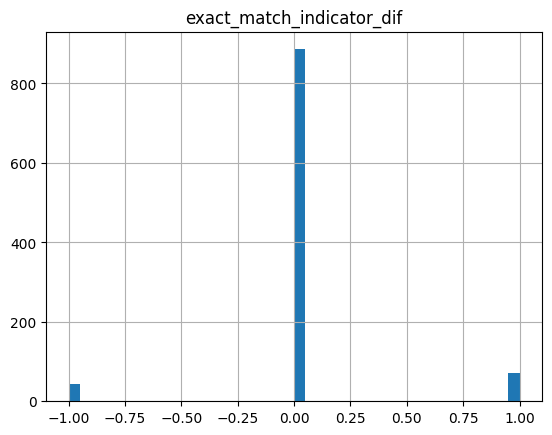

In [4]:

def compare_beams_by_metric(analysis_df,compare_metric,compare_beams, compare_func= lambda a,b: b-a,plot_histogram=True):

    for beam_num in compare_beams:
        filtered_df=analysis_df.loc[analysis_df['beam_num']==beam_num]
        print(f"Mean {compare_metric} for {beam_num}:\t {filtered_df[compare_metric].mean()}")
    
    compare_cols=[f"{compare_metric}_{beam_num}" for beam_num in compare_beams]
    dif_col=f'{compare_metric}_dif'
    
    
    index_cols=['instanceID',  'task_name', 'model']
    
    result = analysis_df[analysis_df['beam_num'].isin(compare_beams)][ ["beam_num"]+index_cols+[compare_metric]]

    pivoted = analysis_df.pivot_table(
        index=index_cols,
        columns='beam_num',
        values=compare_metric,
        # aggfunc='mean'  # or 'first' if there's only one value per group
    ).reset_index()

    pivoted = pivoted.rename(columns={
        compare_beams[0]: compare_cols[0],
        compare_beams[1]: compare_cols[1]
    })

    print("Pivot head:\n\n")
    print(pivoted.head(1))


    pivoted[dif_col] = pivoted.apply(lambda row: compare_func(row[compare_cols[0]],row[compare_cols[1]]), axis=1)
    print(f"Mean Change:{pivoted[dif_col].mean()}")
    print(f"Median Change:{pivoted[dif_col].median()}")
    if(plot_histogram):
        pivoted.hist(column=dif_col,bins=40)

examples_df, completions_df=get_dfs(processGens=processGens, num_beams_list=num_beams_list)
last_beam=num_beams_list[-1]
first_beam=num_beams_list[0]
print(completions_df.columns)
# compare_beams_by_metric(analysis_df=completions_df,compare_metric='output_logprob', compare_beams=[last_beam, first_beam])
compare_beams_by_metric(analysis_df=completions_df,compare_metric=compare_metric, compare_beams=[last_beam, first_beam])
# plot_keys("completion_logprob","BLEU")

# x=completions_df[(completions_df["task_name"]==0) & (completions_df["model"]==0) & (completions_df["beam_num"]==last_beam) & (completions_df["instanceID"]=="id33626")   ]
# print(x)


# beam_num=next(iter(processGens.beam_num_to_summary))
# instance_generations_by_id=get_instance_generations_by_id()
# get_beam_means()
# get_beam_probs()
# check_completion_logprob(beam_num)
# check_sentence_logprob(beam_num)
# see_overlap_per_instance_generation(num_beams_list[-1], num_instances=10)

# if(processGens.metrics_df is not None):
#     ax1 = processGens.metrics_df.plot.scatter(x='beam_num',y='comet',c='DarkBlue')


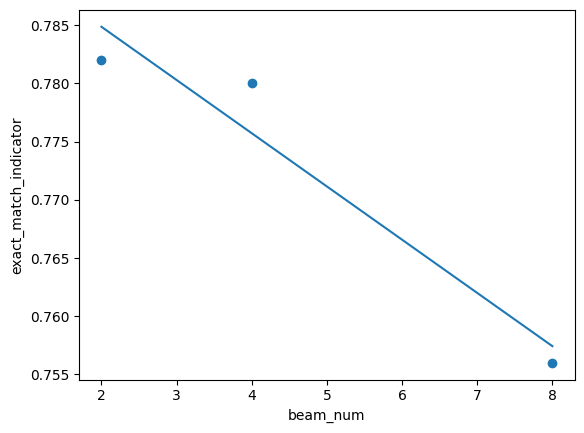

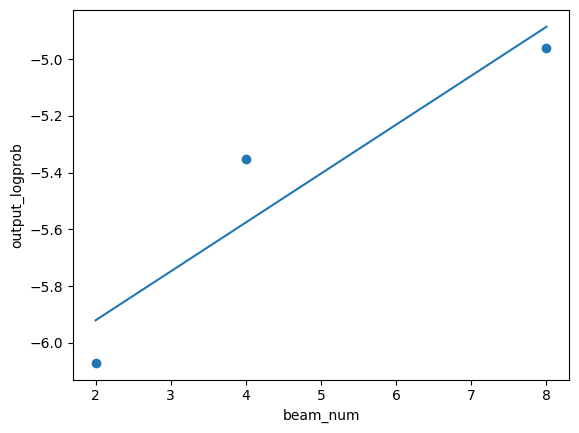

In [6]:
# def plot_beam_averages(analysis_df):

# plot_beam_averages(completions_df)



def plot_grouped(xlabel, ylabel, group_metric, analysis_df):
    keep_cols=list(set([xlabel, ylabel, group_metric]))
    grouped_df = analysis_df[keep_cols].groupby(group_metric, as_index=False).mean()
    plot_keys(grouped_df, xlabel, ylabel)

plot_grouped(xlabel="beam_num", ylabel=compare_metric, group_metric="beam_num", analysis_df=completions_df)
plot_grouped(xlabel="beam_num", ylabel="output_logprob", group_metric="beam_num", analysis_df=completions_df)